In [2]:
import sys
import os
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

import sbgm

sys.path.append(os.getcwd())

from configs import moons_config 

In [3]:
datasets_path = "."
root_dir = "."

config = moons_config()

sharding, replicated_sharding = None, None # Just use CPU for now

In [4]:
key = jr.key(config.seed)
data_key, model_key, train_key = jr.split(key, 3)

dataset = sbgm.data.moons(data_key)

In [5]:
# Diffusion model 
model = sbgm.models.get_model(
    model_key, 
    config=config,
    model_type=config.model.model_type, 
    data_shape=dataset.data_shape, 
)

# Stochastic differential equation (SDE)
sde = sbgm.sde.get_sde(config.sde)

In [6]:
# Fit model to dataset
model = sbgm.train.train_from_config(
    train_key,
    model,
    sde,
    dataset,
    config,
    reload_opt_state=False,
    sharding=sharding,
    replicated_sharding=replicated_sharding,
    save_dir=root_dir
)

Training SGM with a VP SDE on moons dataset.


100%|██████████| 100000/100000 [23:23<00:00, 71.23it/s, Lt=2.075E-01, Lv=2.205E-01]


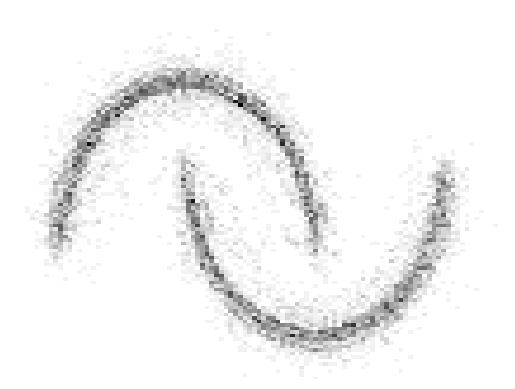

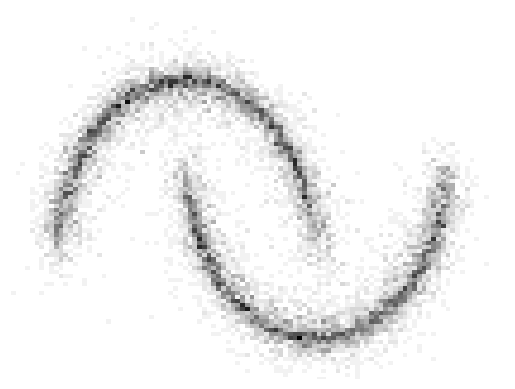

In [7]:
n_sample = 10_000

key_A, key_sample = jr.split(key)
key_samples = jr.split(key, n_sample)

ode_sample_fn = sbgm.sample.get_ode_sample_fn(model, sde, dataset.data_shape)
samples = jax.vmap(ode_sample_fn, in_axes=(0, None, None))(key_samples, None, None)

plt.figure()
plt.hist2d(*samples.T, bins=100, cmap="gray_r")
plt.ylim(-1.6, 1.5)
plt.xlim(-2.5, 3.)
plt.axis("off")
plt.show()

eu_sample_fn = sbgm.sample.get_eu_sample_fn(model, sde, dataset.data_shape)
samples = jax.vmap(eu_sample_fn, in_axes=(0, None, None))(key_samples, None, None)

plt.figure()
plt.hist2d(*samples.T, bins=100, cmap="gray_r")
plt.ylim(-1.6, 1.5)
plt.xlim(-2.5, 3.)
plt.axis("off")
plt.show()

Now we can estimate the log-likelihood across the whole data space.

First, with an exact log-likelihood estimate, which is very expensive for high-dimensional data...

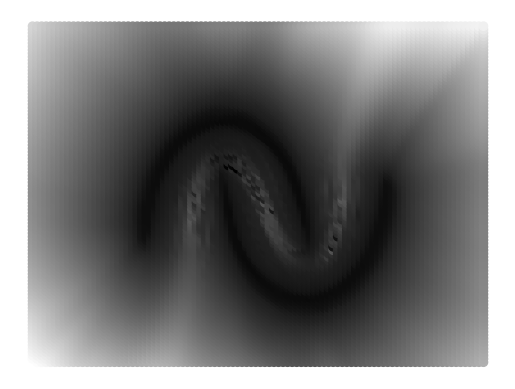

In [8]:
x, y = jnp.mgrid[-4.:4.:100j, -2.:2.:100j]
X = jnp.stack([x.ravel(), y.ravel()], axis=1)

log_likelihood_fn = sbgm.ode.get_log_likelihood_fn(
    model, sde, data_shape=dataset.data_shape, exact_log_prob=True
)
L_X = jax.vmap(log_likelihood_fn, in_axes=(0, None, None, None))(X, None, None, None)

plt.figure()
plt.scatter(*X.T, c=L_X, cmap="gray_r")
plt.axis("off")
plt.show()

...and next with an approximate log-likelihood estimate, based on using the Hutchinson trace estimator.

We use 32 noise realisations for the trace estimator; this looks reasonable!

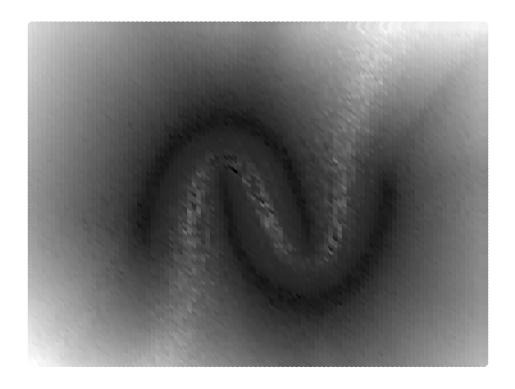

In [9]:
keys = jr.split(key, X.shape[0])

log_likelihood_fn = sbgm.ode.get_log_likelihood_fn(
    model, sde, data_shape=dataset.data_shape, exact_log_prob=False, n_eps=32
)
L_X = jax.vmap(log_likelihood_fn, in_axes=(0, None, None, 0))(X, None, None, keys)

plt.figure()
plt.scatter(*X.T, c=L_X, cmap="gray_r")
plt.axis("off")
plt.show()